## Parameterized Quantum Circuit(PQC):

### Data Encoding

### Quantum Circuit

In [ ]:
# IMPORTS
import pennylane as qml
import numpy as np
import scipy as sp
from abstract import ForecastingMethod
from numpy import ndarray

In [3]:
N_WIRES = 12

In [ ]:
dev = qml.device("default.qubit", wires=N_WIRES)


def encode_circuit(phi_ary: np.ndarray):
    for wire in range(N_WIRES):
        qml.RY(phi_ary[wire], wires=wire)


def apply_layer(layer_theta_ary: np.ndarray):
    """
    A function that applies a layer of RX and RY rotations

    Args:
        theta_ary (np.ndarray): 1D array of angles for both RX and RY gates.
    """
    theta_index = 0
    for wire in range(N_WIRES):
        qml.RX(layer_theta_ary[theta_index], wires=wire)
        theta_index += 1
        qml.RY(layer_theta_ary[theta_index], wires=wire)
        theta_index += 1


@qml.qnode(dev)
def quantum_circuit(phi_ary: np.ndarray, theta_ary: np.ndarray):
    """
    A quantum circuit that encodes the data before applying 2 layers of RX and RY rotations followed by a series of CNOT gates.

    Args:
        phi_ary (np.ndarray): Array of angles for encoding the data.
        theta_ary (np.ndarray): 2D array of angles theta_ary[layer][gate ] for both RX and RY gates.

    Returns:
        np.ndarray: The final state vector of the quantum circuit.
    """
    # Encode the data
    encode_circuit(phi_ary)

    # Apply the first layer
    # Layer 1 Entanglements
    for wire in range(0, N_WIRES - 1, 2):
        qml.CNOT(wires=[wire, wire + 1])
    # Layer 1 RX and RY rotations
    apply_layer(theta_ary[0])

    # Apply the second layer
    # Layer 2 Entanglements
    for wire in range(1, N_WIRES - 1, 2):
        qml.CNOT(wires=[wire, wire + 1])
    qml.CNOT(wires=[N_WIRES - 1, 0])
    # Layer 2 RX and RY rotations
    apply_layer(theta_ary[1])

    return qml.expval(qml.PauliZ(0))

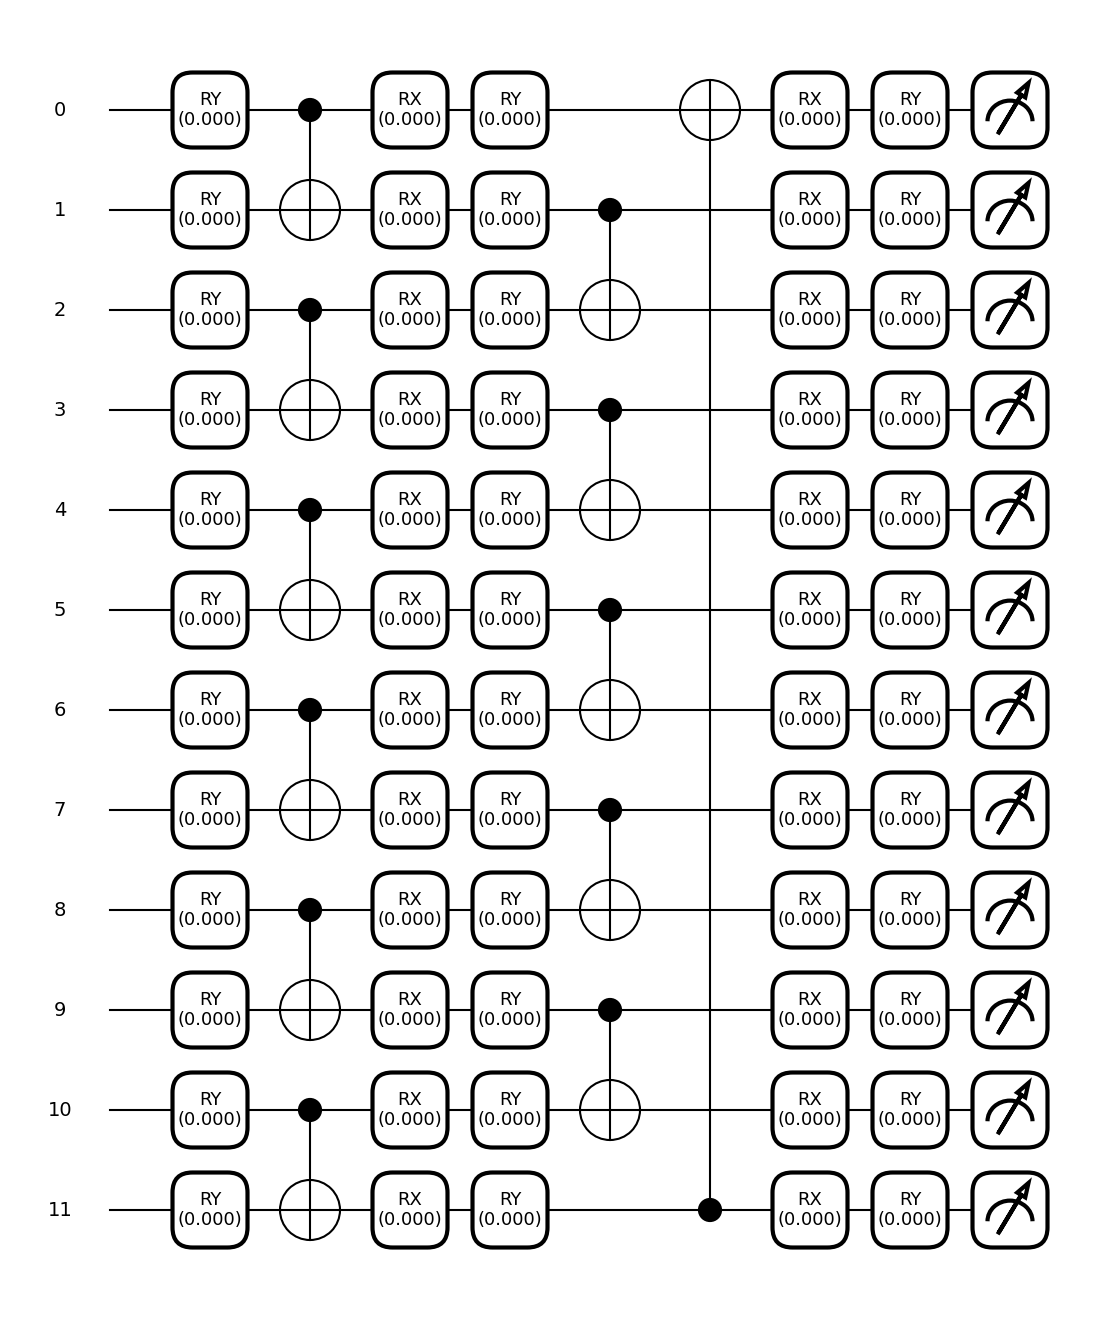

In [ ]:
qml.draw_mpl(quantum_circuit)(np.zeros(N_WIRES), np.zeros((2, N_WIRES * 2)))

### PQC Model Object

In [ ]:
class PQC_Forecast(ForecastingMethod):
    """
    A class that implements a quantum circuit for forecasting.

    Args:
        ForecastingMethod (class): The base class for forecasting methods.
    """

    def __init__(self, n_wires=N_WIRES, n_layers=2):
        super().__init__()
        self.n_wires = n_wires
        self.n_layers = n_layers
        self.dev = dev
        self.theta_ary = np.zeros((self.n_layers, self.n_wires * 2))

    def train(self, train_X: ndarray, train_y: ndarray) -> None:
        # use scipy.optimize.minimize to optimize the theta_ary
        def cost_function(theta_ary_flattened):
            mean_squared_error = 0

            # Reshape the flattened theta_ary to its original shape
            # rows = n_layers, columns = n_wires * 2(1 for RX and 1 for RY)
            theta_ary = theta_ary_flattened.reshape(
                self.n_layers, self.n_wires * 2
            )

            for i in range(len(train_X)):
                example = train_X[i]
                label = train_y[i]
                phi_ary = example
                prediction = quantum_circuit(phi_ary, theta_ary)
                error = prediction - label
                mean_squared_error += error**2
            return mean_squared_error

        # Initial guess for theta_ary(flattened to single array)
        initial_theta_ary = np.random.rand(self.n_layers, self.n_wires * 2)
        # Optimize the cost function
        result = sp.optimize.minimize(
            cost_function, initial_theta_ary, method="L-BFGS-B"
        )
        # Update the theta_ary with the optimized values
        self.theta_ary = result.x.reshape(self.n_layers, self.n_wires * 2)

    def save_weights(self, filepath: str) -> bool:
        try:
            np.save(filepath, self.theta_ary)
            return True
        except Exception as e:
            print(f"Error saving weights: {e}")
            return False

    def load_weights(self, filepath: str) -> bool:
        try:
            self.theta_ary = np.load(filepath)
            return True
        except Exception as e:
            print(f"Error loading weights: {e}")
            return False

    def predict(self, test_X: ndarray) -> ndarray:
        predictions = []
        for example in test_X:
            phi_ary = example
            prediction = quantum_circuit(phi_ary, self.theta_ary)
            predictions.append(prediction)
        return np.array(predictions)

### Training